## RQ2 Text Analysis

General plan:
- Follow a similar approach to the Chai-Allah "Data Mining..." paper to create clusters from the data
    - Just use tokenisation first, if 2 big then use lemmatisation
    - for now, just use all words (don't worry about filtering for high frequency words)
    - Use a German version of the word2vec model (see what the baroni one is based on and try to find a German equivalent)
    - use k-means or ward's for the clustering

Steps:
1. Initial Cleaning
2. Language Handling 
3. Tokenisation
4. Pre-processing (filtering stop words etc, lower-case)
5. Semantic analysis (word2vec)
6. Clustering


In [1]:
# SETUP

# Import packages
import pandas as pd
import numpy as np
import pickle

import spacy 
from langdetect import detect
from deep_translator import GoogleTranslator
from collections import Counter
from gensim.models import KeyedVectors  # requires scipy version 1.12 (anything newer doesn't work)


from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
from wordcloud import WordCloud


### Step 1: Initial Cleaning

General text preparation to get the data in a format which works for translation and for use with spacy.

Decided not to use the comments as there is no guarantee the comments are an expression of someone's perception about the trail/landscape (they might just be saying the trail looks nice from the original posters description, they might be commenting on the directions, etc)

In [7]:
# STEP 1: LOAD & CLEAN

# Load the master CSV from rq2_step1_data_collection
master = pd.read_csv("./processing/master.csv")

# Add ['None'] to any blank rows
# this is necessary for the next step, but then they will be removed later
master.fillna("['None']", inplace=True)

# Extract the description and captitions and combine them into a single column
raw_text = pd.DataFrame()
raw_text["desc_capt"] = master["description text"] + " " + master["photo_captions"]

# Now remove all the ['None'] text from both columns
raw_text["desc_capt"] = raw_text["desc_capt"].str.replace(r"\['None'\]", "", regex=True)

# Remove certain special characters
raw_text["desc_capt"] = raw_text["desc_capt"].str.replace(r"\[", "", regex=True)
raw_text["desc_capt"] = raw_text["desc_capt"].str.replace(r"\]", "", regex=True)
raw_text["desc_capt"] = raw_text["desc_capt"].str.replace(r"\'", "", regex=True)
raw_text["desc_capt"] = raw_text["desc_capt"].str.replace(r"\|", "", regex=True)
raw_text["desc_capt"] = raw_text["desc_capt"].str.replace(r"\\", "", regex=True)
raw_text["desc_capt"] = raw_text["desc_capt"].str.replace(r"\/", "", regex=True)
raw_text["desc_capt"] = raw_text["desc_capt"].str.replace(r"\+", "", regex=True)
raw_text["desc_capt"] = raw_text["desc_capt"].str.replace(r"=", "", regex=True)

# This is to address a specific issue in one of the entries
raw_text["desc_capt"] = raw_text["desc_capt"].str.replace(r"\n", " ", regex=True)

# Create a list from the column
raw_text_list = raw_text["desc_capt"].astype(str).values.tolist()

# Convert entries which are just a space (" ") to be empty ("")
raw_text_list = [x.strip(' ') for x in raw_text_list]

# Remove all empty entries
raw_text_list = list(filter(None, raw_text_list))

# Check
raw_text_list

['Schönmünzach',
 'Altenheim',
 'Wanderung vom Goldenen Anker in Zwingenberg nahe der Neckarbrücke nach Eberbach über Burg Stolzeneck Zwingenberg Brücke, Zwingenberg Burg, Ziegen, Zwingenberg Burg, 1, Umgefallener Baum, 2, 3, Abzweigung, Abzweigung, Schlossblick, Bergbrunnen, Wildrosen, Abzweigung, Reihersee, Abzweigung, Ausblick auf den Neckar, Abzweigung rechts, Abzweigung, 4, Burg Stolzeneck, Burg Stolzeneck, Wegweiser, Bachlauf, Fingerhut, 5, Aussicht, Abzweigung Richtung Rockenau, Steinbruch, Abzweigung rechts, Blick auf Rockenau über Friedhof, Abzweigung, Blick auf Eberbach, Zur Stadt, Foto, Statue, Kirche',
 '3.5 miles down hill. Some water. 3.5 miles back up hill. Photo, Photo',
 'Ruta circular sencilla. El desnivel real es de 420m (error en el altímetro del GPS). En el punto de partida se puede dejar bien el coche al principio del camino. En el lado de la pista justo pasada la mesa de pícnic. Foto, Foto, Foto, Foto, Foto, Foto, Foto, Foto, Foto, Foto, Foto, Foto, Foto',
 'Alte

### Step 2: Language Handling: Translate to German

As the vast majority of text is in German, I will use this as the base language. I have the option now to either remove anything not in German or to translate it. Although translation is not ideal (maybe some of original meaning is lost/altered), I think this is a better option than just removing the other languages entirely. So here I will tranlsate everything into German. 

As there were some issues with this at first, Ross suggested only translating when there are enough words, for example at least 3 unique tokens. Any language detection algorithm will struggle more when there are only 1 or 2 unique words to go on. This requires some preliminary tokenisation to get the count of unique tokens. **I then discard the text for a trail if it has less than 3 unique tokens (most of these are places where people have used the "Foto" placeholder)**


langdetect package: https://anaconda.org/conda-forge/langdetect 
- Use to check if already German

deep-translator package: https://pypi.org/project/deep-translator/
- Using Google Translate as it doesn't require API key (DeepL requires API key)


count_dict = dict(zip(raw_text_list, unique_token_counts))

In [8]:
# STEP 2: FILTER OUT SHORT TEXTS

# Load the spacy model
nlp = spacy.load("de_core_news_sm")

# Create an empty list to store the unique token counts for each trail
unique_token_counts = []

# Tokenise the text for each trail & count the number of unique tokens for each trail
for trail_text in raw_text_list:
    doc = nlp(trail_text)
    tokens = [token.text.lower() for token in doc if not token.is_punct and not token.is_space]
    unique_tokens = set(tokens)
    unique_token_counts.append(len(unique_tokens))

# Combine results into a df
raw_text_counts = pd.DataFrame()
raw_text_counts["text"] = raw_text_list
raw_text_counts["unique_tokens"] = unique_token_counts

# Filter df to only include rows where unique_tokens >= 3
raw_text_counts = raw_text_counts.loc[(raw_text_counts["unique_tokens"] >= 3)]

# Save the text column as a list for use in the next steps
raw_text_3token_list = raw_text_counts["text"].astype(str).values.tolist()

# Check
raw_text_3token_list



['Wanderung vom Goldenen Anker in Zwingenberg nahe der Neckarbrücke nach Eberbach über Burg Stolzeneck Zwingenberg Brücke, Zwingenberg Burg, Ziegen, Zwingenberg Burg, 1, Umgefallener Baum, 2, 3, Abzweigung, Abzweigung, Schlossblick, Bergbrunnen, Wildrosen, Abzweigung, Reihersee, Abzweigung, Ausblick auf den Neckar, Abzweigung rechts, Abzweigung, 4, Burg Stolzeneck, Burg Stolzeneck, Wegweiser, Bachlauf, Fingerhut, 5, Aussicht, Abzweigung Richtung Rockenau, Steinbruch, Abzweigung rechts, Blick auf Rockenau über Friedhof, Abzweigung, Blick auf Eberbach, Zur Stadt, Foto, Statue, Kirche',
 '3.5 miles down hill. Some water. 3.5 miles back up hill. Photo, Photo',
 'Ruta circular sencilla. El desnivel real es de 420m (error en el altímetro del GPS). En el punto de partida se puede dejar bien el coche al principio del camino. En el lado de la pista justo pasada la mesa de pícnic. Foto, Foto, Foto, Foto, Foto, Foto, Foto, Foto, Foto, Foto, Foto, Foto, Foto',
 'Zwingenberg - Eberbach Foto, Foto, 

DUPLICATE HANDLING

At this point I noticed sometimes there were duplicates in the text. I checked the original master csv and saw that sometimes the same trail is listed twice with different URLs. Sometimes there are slight differences (for example one being classified as road bike, and the other as "unspecified", or having slightly different titles), but the text descriptions &/or captions are the same. So I guess this is an issue with a user uploading the same thing twice or a glitch with Wikiloc.

To handle this, if the texts are the exactly same I remove one of them.

In [9]:
# STEP 2: DUPLICATE TEXT HANDLING

# Check for duplicates and preserve order
seen = set()
raw_text_3token_list_unq = []
for item in raw_text_3token_list:
    if item not in seen:
        seen.add(item)
        raw_text_3token_list_unq.append(item)

raw_text_3token_list_unq

len(raw_text_3token_list_unq)

1679

For the next step I originally tried using langdetect to detect whether the text was already in German and then passing anything not in German to deep_translator for the actual translation. I found this didn't always work that well and had issues with it failing to translate or translating when it didn't need to. I therefore tried an alternate approach where deep_translator is used for everything (the auto language detection is used and then everything that is not already German is translated to German; text already in German is skipped).

I compared both approaches for a subset of the data (Bremen, Niedersachsen and Saxony-Anhalt trails - 289 trails total) and found that the success rate was better for the deep_translator only approach, so I have continued with this approach. See details below.

| Category                         | Combo Lang Detect & Deep Translator | Deep Translator Only |
| -------------------------------- | ----------------------------------- | -------------------- |
| DE correctly recognised          | 201                                 | 211                  |
| successful translation           | 33	                                 | 48                   |
| mixed lang - unchanged	       | 5	                                 | 3                    |
| mixed lang - some issues	       | 9	                                 | 6                    |
| unneeded translation	           | 6	                                 | 4                    |
| failed to translate	           | 14	                                 | 6                    |
| incorrect translation	           | 7	                                 | 4                    |
| unneeded & incorrect translation | 14 	                             | 7                    |
| Total	                           | 289	                             | 289                  |
| Success Rate	                   | 80.97%                              | 89.62%               |



In [10]:
# STEP 2: TRANSLATE TO GERMAN (RUN ONCE)

raw_text_de = []
translated_count = 0
skipped_count = 0

# Use deep translator to automatically detect language and translate to German
# If German is detected it will skip the entry (ie. it will not try to translate)
for trail_text in raw_text_3token_list_unq:
    translated = GoogleTranslator(source='auto', target='de').translate(text=trail_text)

    # Check if translation changed anything
    if translated.strip() == trail_text.strip():
        skipped_count += 1
    else:
        translated_count += 1

    raw_text_de.append(translated)

print(f"Translated: {translated_count}")
print(f"Skipped (already German or unchanged): {skipped_count}")
print(f"Percent translated: {round(((translated_count/(translated_count+skipped_count))*100),2)}")



NotValidLength: Brugje over waterloop, Brugje over waterloop, Waterval, Waterval, Das Butzerbachtal, Das Butzerbachtal, Waterval, Waterval, Hangbrug over waterloop, Hangbrug over waterloop, Uitzicht, Uitzicht, Römisches Kupferbergwerk (Pützlöcher), "Ongeveer 1700 meter ten noorden van de kerk van Butzweiler op de helling van het Butzerbachtal. Beschrijving: Boven het Butzerbachtal in het gebied van de Pützlöcher uitgestrekte sporen van een oude en moderne tijd die erts en steenwinning bereiken. Bij een ertsontginning in het midden van de 2e eeuw na Christus gaan meer dan negen, tot 18 meter diepe, welvette schachten terug, die gebaseerd zijn op de huidige bevindingen in de eerste plaats naar Mutungsschächte. Deels zijn deze schachten verbonden door jongere galerijen uit de 18e en 19e eeuw. In aanvulling op het jaar 1781 boven de ingang van de lodge, aanwijzingen bieden verschillende boorgaten toe te schrijven aan recente explosies. Blijkbaar is de Erzausbeute relatief laag was in de Romeinse tijd - de koperhoudende rock (azuriet en malachiet) is gelegen in smalle schil-achtige lagen - zodat we gaven het erts in het voordeel van een steengroeve al in de tweede helft van de 2e eeuw. Talrijke sleuven, wigvormige en hefboomgaten die zijn gevormd door kubusvormige en stapvormige steile wanden, kunnen worden gezien als een regengroeve. De zichtbare oppervlakken en scheiden sleuven gelijkmatig aangebracht koppel Ruhr zie naast elkaar Spitz karbonades bereiken met toenemende diepte toenemende radius en leveren de karakteristieke gebogen patroon. Soms dragen de cuboïden, die in alle stadia van de productie zijn, nog steeds merktekens of cijfers (IV, V). Boven de ingang van de lodge lezen we MARCI, misschien de naam van de eigenaar of huurder van de steengroeve, die we ook op talloze blokken van de Porta Nigra vinden, zodat ook hier cuboïden voor de bouw van het meest beroemde Triergebouw geleverd konden worden. Helaas, in de laatste decennia van de 19e eeuw, begon de steenindustrie opnieuw, waarin vele sporen van oude sporen uit de oudheid en zelfs in de jaren 30 van onze eeuw een Romeinse inscriptie werden verwijderd.", Geyersley ultzichtspunt, Geyersley ultzichtspunt, "Mistfotos in het bos", "Mistfotos in het bos", Eifelkreus, Eifelkreus, Brug over waterloop, Brug over waterloop, Genovevahöhle, De Genoveva grot (voorheen Kuttbachhöhle genoemd) is een legendarische klein hol buurt koord in de wijk Trier-Saarburg ( Rheinland-Pfalz ) dat als natuurmonument 1 wordt weergegeven. n nDe Genoveva grot (voorheen Kuttbachhöhle genoemd) is een legendarische klein hol buurt koord in de wijk Trier-Saarburg ( Rheinland-Pfalz ) dat als natuurmonument wordt weergegeven. n nDe Genoveva grot bevindt zich in de zuidelijke Eifel ongeveer 3,75 kilometer ( rechte lijn ) ten zuid-zuidoosten van de kern plaats van het koord. Het is gelegen in het westen boven het kleine Kutbachs (ook Kuttbach genoemd), een zuidwestelijke zijrivier van de Kyll , ongeveer 550 m ten zuidwesten van de piek van 306,2 meter boven de zeespiegel. NN hoge vesting . Op deze berg de voormalige Keltische wordt Fliehburg bolwerk ( natuurmonument ), gelegen aan de oostelijke flanken vooral de steile kliffen Elterlay en Kutlei (natuurmonumenten). n nHet breedste deel van de Genoveva-grot is ongeveer 15 meter hoog en het plafond is ongeveer 8 tot 10 meter hoog. De treden naar de grot werden in 1910 uit de zandstenen rots uitgehouwen door de Ortsgruppe Kordel van de Eifelverein . n nDe grot bevatte enkele kleinere hutten. Het aangebouwde terras was alleen te bereiken met ladders, breien of klimbossen. De staafgaten en balksteunen met de gewenste regelmaat zijn nog steeds duidelijk zichtbaar. n nIn de puinhelling voor de grot werd een schraper gevonden, die al een gebruik suggereert in het latere Paleolithicum . Daarin werden gevonden naast prehistorische en Romeinse en Frankische scherven. n nTot het midden van de 19e eeuw was de Genoveva-grot alleen bekend onder de naam Kuttbachhöhle. Een functionaris uit Mayen werd overgeplaatst naar Pfalzel . Toen hij deze grot op een wandeling zag, herinnerde hij zich de inheemse Genoveva-legende . Volgens Palatine is graaf Siegfried Genoveva, de dochter van de hertog van Brabant, getrouwd. Toen hij eens een vete deed, beschuldigde de rentmeester Golo na de terugkomst van de graaf zijn vrouw van ontrouw. Ze werd met haar zoon uitgeworpen en vluchtte met haar kind in de Ardennenbos. Ze leefden jammerlijk over de vruchten van het bos en een hinde gaf ze melk. Na jaren vond de graaf Palatijn zijn vrouw en zoon opnieuw. Vreugdevol en met boetvaardigheid pakte hij haar weer op. De slechte Golo ontving zijn welverdiende straf. n nDe tijdgeest van de romantiek , die van verwoeste kastelen en gerelateerde legendes hield, heeft zeker geholpen om deze legende te verspreiden. Dus de Kuttbachhöhle werd de Genovevahöhle., Klausenhöhle, Klausenhöhle, Burg Ramstein, De ruïnes van het kasteel Ramstein staat op een 182 meter hoge rode zandstenen klif aan de rand van de Meulenwaldes in de lagere Kyll-vallei bij Kordel in Rijnland-Palts en behoort daarmee tot het type bergkasteel . n nIn het begin van de 14e eeuw door de Trier aartsbisschop Diether van Nassau als opvolger van een versterkte landhuis gebouwd, het was voortaan een Kurtrierische feodale kasteel dat op electorale onderwerpen en Domdechanten werd toegekend. Tijdens de negenjarige oorlog , werd de fabriek bezet door Franse soldaten en geblazen 1689 Een reconstructie was weggelaten. De opvolger van de voormalige binnenplaats van het kasteel wordt nu gebruikt als een restaurant van het hotel. n nHet kasteel Ramstein bestaat uit een kernkasteel en de bijbehorende commerciële gebouwen op een ongeveer 37 × 57 meter 12 groot gebied in een ovale vorm. Van de voormalige ringmuur en de hoektorens zijn slechts kleine overblijfselen aanwezig. Het gotische hoofdkasteel bestaat uit een woontoren op een trapeziumvormig plan met afmetingen van 13 × 10,8 meter. 13 Ondertussen, ongeveer 1,35 meter dikke buitenmuren van droge stenen waren ooit naar schatting 25 voet hoog en bestaat uit vier verdiepingen. 13 Van deze drie, op sommige plaatsen zelfs slechts twee verdiepingen met een maximum hoogte van 18 meter 13ontvangen. Aan de binnenkant van de muren zijn de gaten van de voormalige balken aan het plafond en resten van zitnissen en schoorstenen herkenbaar. Als kledingstukken werd grijs en rood zandsteen uit de omgeving gebruikt. De torenvensters hebben meestal gotische panelen met drie doorgangen . n nHeel goed bewaard gebleven is de 1,55 meter 14 brede en 2,45 meter 14 hoge toegangspoort aan de westkant van de toren, die wordt gescheiden door een 4,70 meter 8 metende halsgeul van de buitenste vestingmuur. Deze brug werd vroeger overbrugd door een houten houten brug. 15 Zodra men bereikt door het vooronder van een snede in de rots stenen trap daar. Benaderingen van hun stappen zijn vandaag nog steeds zichtbaar. n nDe vloeren van de toren waren wenteltrappen in twee rondes, van Haustein gebouwd trappenhuizen zijn ontwikkeld op de noordoostelijke hoek en aan de buitenkant van de zuidelijke muur in de buurt van de hoofdingang. Op de begane grond was de grootste open haard van het huis, dus kan worden aangenomen dat er de keuken was. 16 Drie andere haarden bestond op de eerste verdieping, de eerder door een vakwerk wand werd in twee helften verdeeld. Misschien waren er de privévertrekken van de kasteelheer. 17 De tweede verdieping was van een enkele grote halwaarschijnlijk gebruikt voor festiviteiten, recepties en vergaderingen. 17 Ontbrekende open haarden op de derde verdieping en dus geen mogelijkheid tot verwarming geven aan dat de accommodatie voor bedienden daar was gelegen. --> Text length need to be between 0 and 5000 characters

In [27]:
# STEP 2: SAVE TRANSLATED TEXT

pickle.dump(raw_text_de, open("./processing/raw_text_de.p", "wb"))

In [28]:
# STEP 2: LOAD TRANSLATED TEXT

raw_text_de = pickle.load(open("./processing/raw_text_de.p", "rb"))

### Step 3: Tokenisation

German spacy model options: https://spacy.io/models/de 

de_core_news_sm (I've installed this one so far)
de_core_news_md
de_core_news_lg
de_dep_news_trf

Which is best to use?

**REVISIT THIS LATER**


In [29]:
# STEP 3: TOKENISATION

# Load the spacy model
nlp = spacy.load("de_core_news_sm")

# Create an empty list to store the tokens
doc = []

# Tokenise the raw_text input
for string in raw_text_de:
    doc.extend(nlp(string))

# Print the tokens to check
#for token in doc:
#    print(token)


### Step 4: Pre-processing 

Remove stop words, punctuation & numbers from the token list. 

Convert all to lower-case.

**Also:** 
- remove the word "Foto" as this is just placeholder text
- "null" is also used as a placeholder sometimes so I have included this as a stop word as well

In [ ]:
# STEP 4: STOP WORDS ETC

# Add words to stop list
nlp.vocab["Foto"].is_stop = True
nlp.vocab["foto"].is_stop = True
nlp.vocab["FOTO"].is_stop = True
nlp.vocab["Fotos"].is_stop = True
nlp.vocab["Photo"].is_stop = True
nlp.vocab["null"].is_stop = True
nlp.vocab["Waypoint"].is_stop = True

# Filter out tokens that are stop words (is_stop), puncutation (is_punct), 
# numbers (is_digit & like_num) OR spaces (is_space)
filtered_tokens = [token.text for token in doc if not token.is_stop | token.is_punct | 
                   token.is_digit | token.like_num | token.is_space]

# Empty list for lower-case versions
filtered_tokens_lc = []

# Convert to lower-case 
for token in filtered_tokens:
    token_lc = token.lower()
    filtered_tokens_lc.append(token_lc)

# Check
print(filtered_tokens_lc)

['finndorff-blockland-st', 'jürgen-ritterhude-findorff', 'pause', 'wümme', 'deich', 'wümme', 'deich', 'picknick', 'möglichkeit', 'bank', 'gastronomie', 'wc', 'gastronomie', 'wc', 'einkehr', 'möglichkeit', 'echterrr', 'kirche', 'st.', 'jürgen', 'möglichkeit', 'picknick', 'wiese', 'eiscafe', 'ritterhude', 'wümme', 'brücke', 'dammsiel', 'seitenwechsel', 'wümme', 'flughafenrunde', 'abzweig', 'park', 'links', 'weser', 'ausgeschildert', 'abzweig', 'hotel', 'robben', 'ochtumdeich', 'fußweg', 'stück', 'schieben', 'wunderbarer', 'weg', 'abzeig', 'picknickplatz', 'badestrand', 'ohz', 'cafe', 'wsv', 'hasenbühren', 'bremen', 'stephaniebrücke', 'strom', 'huchting', 'knotenpunkt', 'abzweig', 'flughafenrunde', 'weg', 'richtung', 'centrum', 'endpunkt', 'stephaniebrücke', 'neustadtseite', 'bremen', 'start', 'silbersee', 'bade-', 'picknick', 'möglichkeit', 'wc', 'wassermühle', 'barrien', 'picknick', 'platz', 'radtour', 'alte', 'luege', 'clausthal', 'zellerfeld', 'nah', 'lautenthal', 'hauptschacht', 'lau

In [31]:
# STEP 4: CHECKING SOME RESULTS? :) 

word_freq = Counter(filtered_tokens_lc)

common_words = word_freq.most_common(20)

common_words


[('hwn', 67),
 ('braunschweig', 65),
 ('weg', 30),
 ('harzer', 28),
 ('links', 27),
 ('rechts', 24),
 ('parkplatz', 21),
 ('wandernadel', 21),
 ('sachsenhagen', 21),
 ('schöne', 19),
 ('brocken', 19),
 ('nummer', 19),
 ('wald', 18),
 ('st.', 17),
 ('start', 17),
 ('export', 16),
 ('km', 15),
 ('bad', 14),
 ('tour', 13),
 ('wanderung', 13)]

I think HWN stands for Harzer Wandernadel: a hiking badge system for the Harz mountains https://en.wikipedia.org/wiki/Harzer_Wandernadel

### STEP 5: Semantic analysis (word2vec)

Using the de_wiki word2vec model from https://sites.google.com/site/fritzgntr/software-resources/semantic_spaces because it is the closest one to the baroni model used in the Chai-allah paper but for German. 

The semantic spaces are provided in .rda format for R but can be export as a txt for use outside R using the following commands (in R). NOTE: I had to adjust from the instruction on the source website as it didn't account for use in gensim, which then meant I had problems with quotes and separators.

 load("C:/Users/ninam/Documents/UZH/04_Thesis/code/nm_forest_thesis/word2vec/de_wiki.rda")

 write.table(de_wiki, file = "C:/Users/ninam/Documents/UZH/04_Thesis/code/nm_forest_thesis/word2vec/de_wiki.txt", row.names = TRUE, col.names = FALSE, quote = FALSE, sep = " ")
 

 Some useful notes/resources:
 - "a word embedding refers to a vector representation of a particular word or phrase in a multidimensional space" (Generally this website is helpful: https://okan.cloud/posts/2022-05-02-text-vectorization-using-python-word2vec/)
 - https://medium.com/@dilip.voleti/classification-using-word2vec-b1d79d375381
 - https://medium.com/@denis.arvizu/text-clustering-using-word2vec-a89fbd9b9d0f

In [ ]:
# STEP 5: MODEL PREP (RUN ONCE!)

# First I need to adjust the encoding and add the header information required by gensim
# Then I can save it in gensim format for easier use

# Count rows and vector size for header info
with open("./word2vec/de_wiki.txt", encoding="ISO-8859-1") as f:
    lines = f.readlines()

num_words = len(lines)
vector_size = len(lines[0].split()) - 1

# Write in utf-8 with header info
with open("./word2vec/de_wiki_utf8_header.txt", "w", encoding="utf-8") as f:
    f.write(f"{num_words} {vector_size}\n")
    f.writelines(lines)

# Load model (from new txt file) with gensim
model = KeyedVectors.load_word2vec_format("./word2vec/de_wiki_utf8_header.txt", binary=False)

# Save the model in optimised gensim format (this will make the loading faster for next time)
model.save("./word2vec/de_wiki_final.model")

In [32]:
# STEP 5: CHECKING MODEL

# Load model from model file
model = KeyedVectors.load('./word2vec/de_wiki_final.model')

# Which tokens are known versus which are missing in model?
known_tokens = [token for token in filtered_tokens_lc if token in model]
unique_known_tokens = set(known_tokens)
unique_known_count = len(unique_known_tokens)

missing_tokens = [token for token in filtered_tokens_lc if token not in model]
unique_missing_tokens = set(missing_tokens)
unique_missing_count = len(unique_missing_tokens)

# Print results
print("Total known tokens", len(known_tokens))
print("Total missing tokens", len(missing_tokens))
print("Percentage absolute missing:", round((len(missing_tokens)/(len(known_tokens)+len(missing_tokens)) *100), 2))
print("-----")
print("Unique known tokens:", unique_known_count)
print("Unique missing tokens:", unique_missing_count)
print("Percentage unique missing:", round((unique_missing_count/(unique_known_count+unique_missing_count)*100), 2))
print("-----")
print("Missing tokens:", unique_missing_tokens)



Total known tokens 2954
Total missing tokens 920
Percentage absolute missing: 23.75
-----
Unique known tokens: 1574
Unique missing tokens: 641
Percentage unique missing: 28.94
-----
Missing tokens: {'lutterzandweg', 'ü.', 'brockenblick', 'göhrden', 'amdreaaberg', 'hwn170', 'startpunt', 'brunnen-10', 'alte-barenaue', 'winterspaziergang', 'ueffeln', 'hafensänger', 'käsewieter', 'dicker-stein-und-dickes-eis', 'nhotels', 'ochtrup-laer', 'acker-landes', 'jägersbeeker', 'weserweg', 'ithturm', 'impresionen', 'rüschpark', 'drilandsee', 'volkensen', 'wegweiser2', 'kennelbad', 'kellbergturm', 'fährmeile', 'welpeloweg', 'www.baxmannbaude.de', 'schnarcherklippen', 'waldgaststatte', 'kupferschieferbau', 'harlyberg', 'schätzendorf', 'breitenrode', 'rabenklippe', 'torhausfrauenkapelle', 'felswerke', 'eckerstausee', 'nordwestgiebel', 'hirschdenkmal', 'hexenaltar', 'buntenbock', 'nonnenstein', 'sofaklippe', 'femo', 'ringgleis', 'bärendenkmal', 'querfeldeinpfade', 'vollkornmehle', 'jägersbleeker', 'wese

In [33]:
# STEP 5: CONVERT TOKENS TO VECTORS (CREATE WORD EMBEDDINGS)

# Load model from model file
model = KeyedVectors.load('./word2vec/de_wiki_final.model')

# Create empty list to store vectors
vectors = []

# Create empty list to store valid tokens (i.e. tokens which are present in the model)
valid_tokens = []

# Store the vectors for each token
for token in filtered_tokens_lc:
    if token in model:
        vector = model[token]
        vectors.append(vector)
        valid_tokens.append(token)


**NOTE**
I thought I had to change the code above so that the tokens were grouped together by their trail (so when determining the vector it takes the context of the words in the correct trail description) - BUT I think this is actually not the way the model works: the model uses a context window of 5 when training the model to create the vectors - but once the vectors are created they are just applied on a word-by-word basis (i.e. bag of words model). The code above basically works the same as the code in this chunk - either is okay.

In [34]:
# STEP 5: COSINE SIMILARITY/DISIMILARITY

# Approximate cosine similarity (for kmeans)
normalised_vectors = normalize(vectors)


### Step 6: Clustering

I'll try it out with k-means first.

First step is to see how many clusters I should make using the elbow method.

Note I got the following error message when running this originally: *UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.* To resolve this I edited the **system environment variables** using the instructions in the first answer here: https://stackoverflow.com/questions/69596239/how-to-avoid-memory-leak-when-dealing-with-kmeans-for-example-in-this-code-i-am

Resources
- GEO881 Assignment 1, Part 2 (kmeans classification - but in R)
- https://www.w3schools.com/python/python_ml_k-means.asp
- https://medium.com/@m3redithw/wordclouds-with-python-c287887acc8b


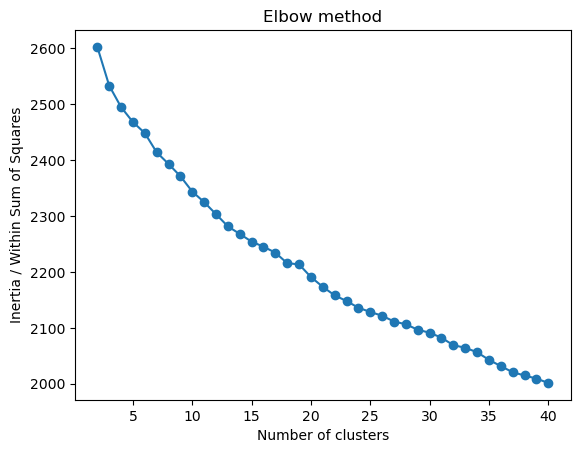

In [35]:
# STEP 6: DETERMINE NUMBER OF CLUSTERS

# Set seed for reproducible results
#np.random.seed(244)

# Create empty list to intertias (within cluster sum of squares)
inertias = []

# Test kmeans intertias/within ss for 2-40 clusters
# Random state needed for reproducible results
for k in range(2,41):
  kmeans = KMeans(n_clusters=k, max_iter=200, random_state=384)
  kmeans.fit(normalised_vectors)
  inertias.append(kmeans.inertia_)

# Generate the elbow plot
plt.plot(range(2,41), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia / Within Sum of Squares')
plt.show() 

Based on plot above - 14 clusters?

In [36]:
# STEP 6: KMEANS WITH 14 CLUSTERS

# Set seed for reproducible results
np.random.seed(11)

# Define number of clusters basedon elbow plot
n_clusters = 14

# Generate kmeans clusters and labels
kmeans = KMeans(n_clusters=n_clusters)
kmeans.fit(normalised_vectors)
labels = kmeans.labels_

# Create a df with the cluster number for each token contained in the model
token_cluster_all = pd.DataFrame({"token": valid_tokens, "cluster": labels})

# Check
token_cluster_all


,token,cluster
0,pause,4
1,wümme,10
2,deich,10
3,wümme,10
4,deich,10
...,...,...
2949,südharz,10
2950,karstwanderweg,13
2951,stempelstelle,13
2952,queste,1


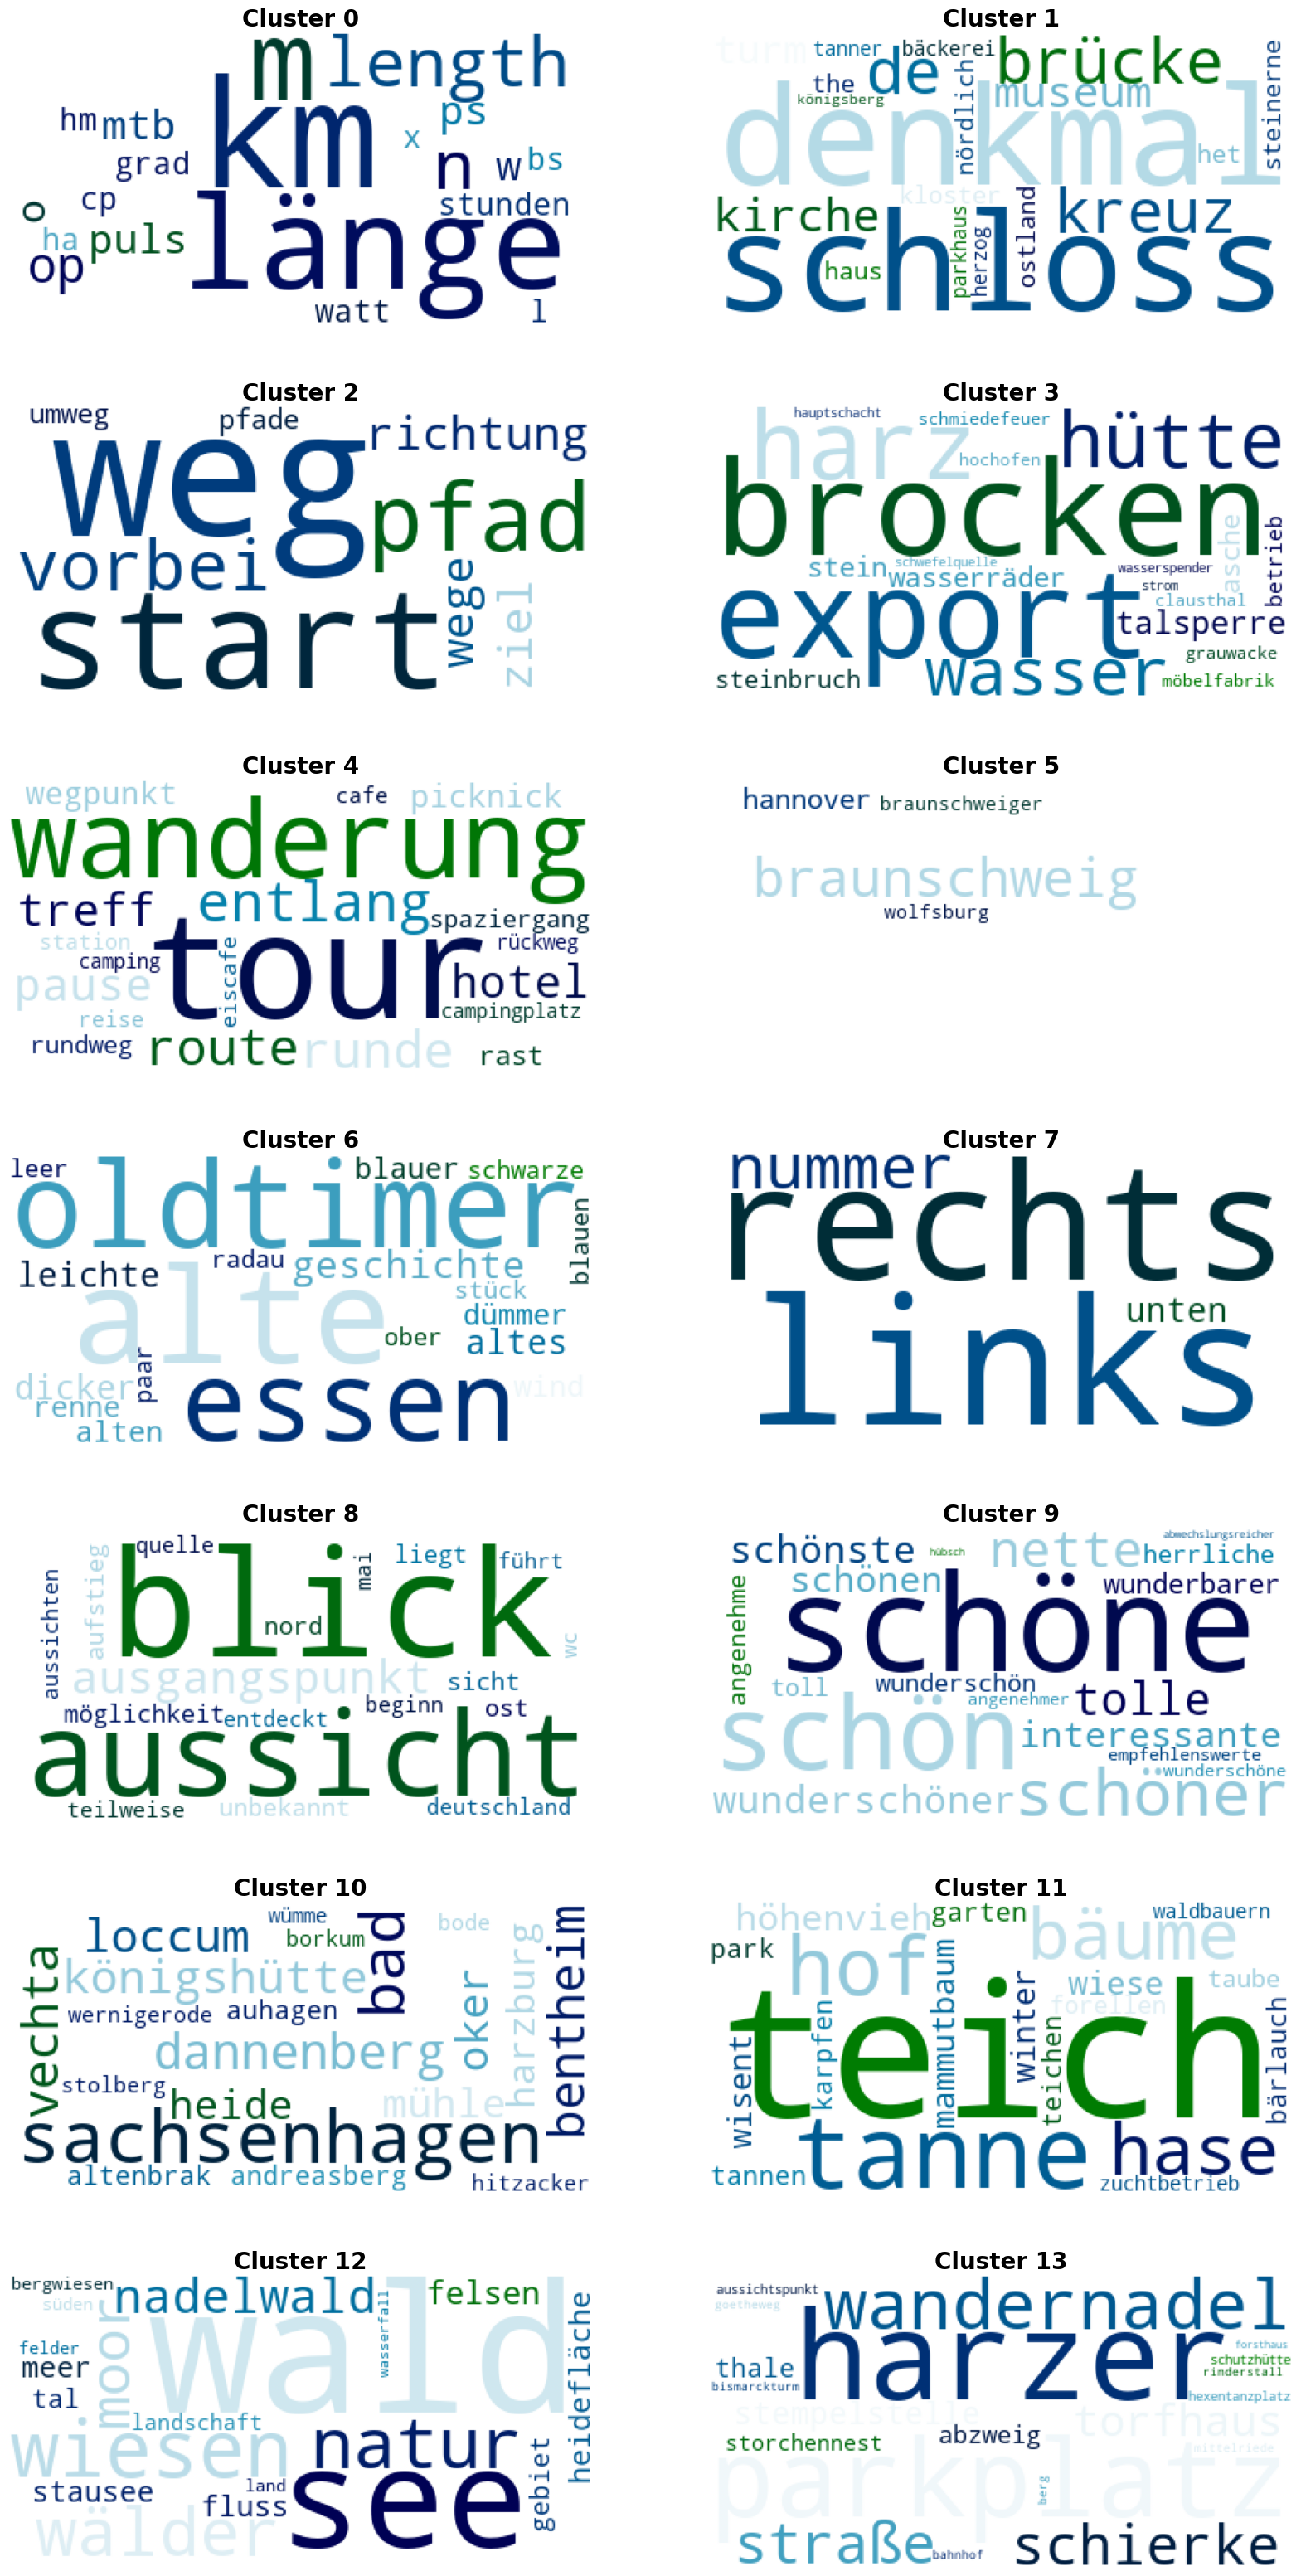

In [37]:
# STEP 6: EXPLORE CLUSTER WORD CLOUDS

# Create a function to count the token frequencies for each cluster 
def get_cluster_freq(df, clus_num):
    token_list = df.loc[df["cluster"] == clus_num, "token"]
    delimiter = " " 
    join_str = delimiter.join(token_list)
    freqs = Counter(join_str.split())
    return freqs

# Create empty lists for storing the word cloud plots 
all_wc = []

# For each cluster number (0-13) use the get_cluster_freq function to get token frequencies,
# input those frequencies into the WordCloud generator and append each wc to list
# IMPORTANT: I HAVE LIMITED TO SHOW TOP 20 TOKENS IN EACH CLUSTER
for clus_num in range(14):  
    freqs = get_cluster_freq(token_cluster_all, clus_num)
    wc = WordCloud(background_color='white', 
                   colormap='ocean', 
                   max_words=20).generate_from_frequencies(freqs)
    all_wc.append(wc)

# Create custom titles
all_titles = ["Cluster 0", "Cluster 1", 
              "Cluster 2",  "Cluster 3", 
              "Cluster 4", "Cluster 5", 
              "Cluster 6", "Cluster 7", 
              "Cluster 8", "Cluster 9",
              "Cluster 10", "Cluster 11",
              "Cluster 12", "Cluster 13"]

old_titles = ["Cluster 0 - Distances/Units", "Cluster 1 - Religion? (spiritual CES?)", 
              "Cluster 2 - Odd mix...",  "Cluster 3 - Nature Words", 
              "Cluster 4 - Placenames", "Cluster 5 - Harz placenames", 
              "Cluster 6 - Trail/Route Words", "Cluster 7 - Placemames", 
              "Cluster 8 - Old things (heritage CES?)", "Cluster 9 - Trail/Route Words",
              "Cluster 10 - Directions/Transportation", "Cluster 11 - Directions"]


# Create a figure with 14 subplots
fig, axes = plt.subplots(nrows=7, ncols=2, figsize=(20, 40))
axes = axes.flatten()

# Iterate through word clouds and titles to plot
for i, (wc, title) in enumerate(zip(all_wc, all_titles)):
    axes[i].imshow(wc)
    axes[i].axis('off')
    axes[i].set_title(title, fontsize=20, fontweight="bold")

# Display final figure
plt.show()


